In [1]:
from utils import *
import numpy as np
import os
from os.path import join
import json
from matplotlib import pyplot as plt
import math
import string
import pickle
import torch

from scipy.ndimage import binary_dilation
from scipy.ndimage.morphology import generate_binary_structure
from time import time

import pandas as pd
import seaborn as sns
%matplotlib inline

torch.cuda.empty_cache()

### Functions that will be used later

In [2]:
def plot_one_slice(array_3d, dim, idx):
    plt.figure(dpi=120)
    if dim=='x':  # shape of array_3d should be z,x,y
        plt.imshow(array_3d[:,idx,:], cmap='Greys')
    elif dim=='y':
        plt.imshow(array_3d[:,:,idx], cmap='Greys')
    elif dim=='z':
        plt.imshow(array_3d[idx,:,:], cmap='Greys')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_merged_slices(array_3d, dim, idx0, idx1):
    plt.figure(dpi=150)
    if dim=='x':  # shape of array_3d should be z,x,y
        to_show=np.max(array_3d[:,idx0:idx1,:], axis=1)
        plt.imshow(to_show, cmap='Greys')  # aspect=2
    elif dim=='y':
        plt.imshow(np.max(array_3d[:,:,idx0:idx1], axis=2), cmap='Greys')
    elif dim=='z':
        plt.imshow(np.max(array_3d[idx0:idx1,:,:], axis=0), cmap='Greys')
    plt.colorbar()
    plt.show()
    
    
def load_npz_to_array(filename, key='arr_0'):
    return np.load(filename)[key]

    
def normalize_to(arr, min_value, max_value):
    arr = arr.astype(np.float32)
    arr -= arr.min()
    arr /= (arr.max() - arr.min())
    arr *= (max_value - min_value)
    arr += min_value
    return arr

In [10]:
def distance_tolerant_F_score(out, gt, tolerance, threshold, f_order, dont_care_mask=None, 
                              radius_weight_matrix=None, radius_grid=None, 
                              max_radius_pivot=None, radius_bin_size=None):
    start0 = time()
    
    # the value range of both the output and the gt should be [0,1]
    assert len(out.shape) == 3
    assert len(gt.shape) == 3
    
    if dont_care_mask is not None:
        dont_care_mask = dont_care_mask.astype(bool)  # important! otherwise may be too slow
        gt[dont_care_mask] = 0
        out[dont_care_mask] = 0
    
    if out.max()>1 and out.dtype=='uint8':
        out = out/255
    if gt.max()>1 and gt.dtype=='uint8':
        gt = gt/255
        gt = gt.astype(np.uint8)

    # thresholding the output to generate the prediction
    pred = (out>=threshold).astype(np.uint8)

    # dilate gt when calculating distance-tolerant precision
    if tolerance!=0:
        dilated_gt = binary_dilation(gt, iterations=tolerance).astype(np.uint8)
    else:
        dilated_gt = gt
    
    tp_p_array = np.logical_and(pred, dilated_gt).astype(int)
    tp_p = tp_p_array.sum()
    precision = tp_p / pred.sum()  # calculate precision as usual even if radius_weight_matrix is not None: because many precision areas are not overlapping with the root weight matrix
    # also weight the prediction, so that the resulting range of precision will be [0,1]
        
    # dilate predition when calculating distance-tolerant recall
    if tolerance!=0:
        dilated_pred = binary_dilation(pred, iterations=tolerance).astype(np.uint8)
    else:
        dilated_pred = pred
    
    tp_r_array = np.logical_and(dilated_pred, gt).astype(int)
    if radius_weight_matrix is None:
        tp_r = tp_r_array.sum()
        recall = tp_r / gt.sum()
    else:
        tp_r = (tp_r_array * radius_weight_matrix).sum()
        recall = tp_r / ((gt * radius_weight_matrix).sum())  
        
    # get recall list according to the radius ranges, for plotting as histogram
    if radius_grid is not None:
        radius_tp_list = []
        radius_gt_list = []
        for i in np.arange(0, max_radius_pivot+radius_bin_size, radius_bin_size):
            if i!=max_radius_pivot:
                voxels_in_rad_range = (radius_grid>i)*(radius_grid<=i+radius_bin_size)
            else:
                voxels_in_rad_range = (radius_grid>i)
            # radius_recall_list.append(tp_r_array[voxels_in_rad_range].sum()/gt[voxels_in_rad_range].sum())
            radius_tp_list.append(tp_r_array[voxels_in_rad_range].sum())
            radius_gt_list.append(gt[voxels_in_rad_range].sum())
    else:
        # radius_recall_list = None
        radius_tp_list = None
        radius_gt_list = None
        
    
    f_score = (1 + f_order**2) * precision * recall / (f_order**2 * precision + recall)
    
    print('distance tolerance:', tolerance)
    print('f_score:', f_score)
    print('precision:', precision)
    print('recall:', recall)
    print('*** total time used:', time() - start0)
    print()
    return f_score, precision, recall, radius_tp_list, radius_gt_list


def get_gt_filename(input_name, super_res, soil_names):
    is_real = True
    for soil_name in soil_names:            
        if input_name.startswith(soil_name):  # combined data
            is_real = False
            input_name = input_name[len(soil_name)+1:]
            #gt_name = 'gt_{}x_{}'.format(int(super_res), input_name)
    gt_name = 'gt_{}x_{}'.format(int(super_res), input_name)
    return gt_name, is_real

    

def generate_tube_mask(mri_shape_zxy, center_x, center_y, rad):
    x = np.arange(0,mri_shape_zxy[1], 1)
    y = np.arange(0,mri_shape_zxy[2], 1)
    x_mesh, y_mesh = np.meshgrid(x, y, indexing='ij')
    # print(x_mesh)
    distance_to_tube_center = np.sqrt(np.square(x_mesh-center_x)+np.square(y_mesh-center_y))
    tube_mask = np.where(distance_to_tube_center<=rad, True, False)
    # print(tube_mask)
    tube_mask = np.expand_dims(tube_mask, axis=0)
    tube_mask = np.tile(tube_mask, (mri_shape_zxy[0], 1, 1))
    # print(tube_mask.shape)
    return tube_mask

In [16]:
tube_mask_info = {'lupine_small_xml_mri.npy': {'center_x':77, 'center_y':127, 'radius':14}, 
                  'Lupine_22august_mri.npy': {'center_x':104, 'center_y':70, 'radius':11}, 
                  'I_Sand_3D_DAP5_mri.npy': {'center_x':88, 'center_y':196, 'radius':10}, 
                  'I_Soil_1W_DAP7_mri.npy': {'center_x':216, 'center_y':146, 'radius':16}, 
                  'I_Soil_4D_DAP7_mri.npy': {'center_x':166, 'center_y':206, 'radius':17}}


def calc_disTolFscore(out_dir, test_data_dir, super_res, train_data_padding, ignore_test_tube = True, probability_threshold = 0.5, 
                      distance_tolerance_range = np.arange(0,15,2), f_order=1, weight_by_radius=False,
                      radius_histogram=False, max_radius_pivot=None, radius_bin_size=None):
    '''
    out_dir: segmentation output directory
    test_data_dir: the directory where test data is stored
    super_res: super resolution factor, usually 2
    train_data_padding: the padding added to the input image before cropping it and input to the network
    ignore_test_tube: if ignore the test tubes when calculating the distance tolerant F1 scores
    probability_threshold: the threshold used to determine the predicted class of each voxel
    distance_tolerance_range: the list of values of distance tolerances, from low to high
    f_order: the order in the F score formula, should be 1 for F1
    weight_by_radius: if to weight the distance tolerant F1 scores with voxel-wise root radius values
    radius_histogram: if there's need to generate the radius histogram, if so, will return a list of recalls 
                      of different radius ranges
    max_radius_pivot: if calculating radius_histogram, the large side of the largest radius range
    radius_bin_size: if calculating radius_histogram, the size of each radius range
    '''
    print('out_dir:', out_dir)
    
    real_data_F_list_dict = {}
    real_data_precision_list_dict = {}
    real_data_recall_list_dict = {}
    
    if radius_histogram:
        radius_gt_list_all = np.zeros(int(max_radius_pivot/radius_bin_size)+1)
        radius_tp_list_all = np.zeros(int(max_radius_pivot/radius_bin_size)+1)

    for input_name in real_test_root_gt_dict:
        output_img = np.load(join(out_dir, 'visualized_out_'+input_name[:-1]+'z'))['arr_0']  # npz file
        gt_dir = join(test_data_dir, 'ground_truth')
        gt = np.load(join(gt_dir, real_test_root_gt_dict[input_name]))
        gt = np.squeeze(gt)
        # print(gt.shape)
        # print(gt.dtype)
        print('%%%%%%%% data name:', input_name)
        real_data_F_list_dict[input_name] = []
        real_data_precision_list_dict[input_name] = []
        real_data_recall_list_dict[input_name] = []
        # print(output_img.shape)
        # print(gt.shape)
        
        if weight_by_radius:  # load the radius weight matrix
            radius_weight_filename = input_name[:-4]+'_radius.npy'
            radius_weight_matrix = np.load(join(test_data_dir, 'radius_grids', radius_weight_filename))
            # reverse the radius weights so that the thinnest has highest weight
            zero_mask = (radius_weight_matrix==0)
            radius_weight_matrix[zero_mask] = 1  # only for save dividing
            # radius_weight_matrix = radius_weight_matrix.max()-radius_weight_matrix
            radius_weight_matrix = (1/radius_weight_matrix)**2  # power 2
            radius_weight_matrix[zero_mask]=0
            print()
        else:
            radius_weight_matrix = None
            
        if radius_histogram:
            radius_weight_filename = input_name[:-4]+'_radius.npy'
            radius_grid = np.load(join(test_data_dir, 'radius_grids', radius_weight_filename))
            print('max of radius_grid:', radius_grid.max())
        else:
            radius_grid = None

        tube_mask = None
        if ignore_test_tube:
            if input_name in tube_mask_info:
                # generate the test tube mask for this data
                center_x = tube_mask_info[input_name]['center_x'] * super_res
                center_y = tube_mask_info[input_name]['center_y'] * super_res
                rad = tube_mask_info[input_name]['radius'] * super_res
                tube_mask = generate_tube_mask(gt.shape, center_x, center_y, rad)


        # if train_data_padding is odd, shift the gt and tube_mask towards (0,0,0), to match the prediction
        # if even, do nothing
        if train_data_padding%2 != 0:
            gt_shifted = np.zeros(gt.shape).astype(np.uint8)
            gt_shifted[:-1, :-1, :-1] += gt[1:, 1:, 1:]
            gt = gt_shifted
            if tube_mask is not None:
                tube_mask_shifted = np.zeros(tube_mask.shape).astype(np.uint8)
                tube_mask_shifted[:-1, :-1, :-1] += tube_mask[1:, 1:, 1:]
                tube_mask = tube_mask_shifted
            if weight_by_radius:
                # also shift the radius weight matrix
                radius_weight_shifted = np.zeros(radius_weight_matrix.shape).astype(np.float32)
                radius_weight_shifted[:-1, :-1, :-1] += radius_weight_matrix[1:, 1:, 1:]
                radius_weight_matrix = radius_weight_shifted
            if radius_histogram:
                # also shift the radius grid
                radius_grid_shifted = np.zeros(radius_grid.shape).astype(np.float32)
                radius_grid_shifted[:-1, :-1, :-1] += radius_grid[1:, 1:, 1:]
                radius_grid = radius_grid_shifted
        
#         # temp experiment, not used usually
#         gt = gt[50:, :, :]  
#         output_img = output_img[50:, :, :]
#         if tube_mask is not None:
#             tube_mask = tube_mask[50:, :, :]
#         if weight_by_radius:
#             radius_weight_matrix = radius_weight_matrix[50:, :, :]
#         if radius_histogram:
#             radius_grid = radius_grid[50:, :, :]

        for t in distance_tolerance_range:
            f_score, precision, recall, \
            radius_tp_list, radius_gt_list = distance_tolerant_F_score(output_img, gt, tolerance=t, 
                                                                   threshold=probability_threshold, 
                                                                   f_order=f_order, dont_care_mask=tube_mask,
                                                                   radius_weight_matrix=radius_weight_matrix,
                                                                   radius_grid=radius_grid,
                                                                   max_radius_pivot=max_radius_pivot,
                                                                   radius_bin_size=radius_bin_size)
            real_data_F_list_dict[input_name].append(f_score)
            real_data_precision_list_dict[input_name].append(precision)
            real_data_recall_list_dict[input_name].append(recall)
            
            if radius_histogram:
                radius_gt_list_all += np.array(radius_gt_list)
                radius_tp_list_all += np.array(radius_tp_list)
                print('radius_gt_list_all:', radius_gt_list_all)
                print('radius_tp_list_all:', radius_tp_list_all)
            
    print('pickling and saving the results...')
    # save the calculated F lists in the model test output directory
    with open(join(out_dir, 'real_data_F_list_dict_probThres{}.pkl'.format(probability_threshold)), 'wb') as f:
        pickle.dump(real_data_F_list_dict, f)
    # at the same time, pickle the distance tolerance range
    with open(join(out_dir, 'distance_tolerance_range.pkl'), 'wb') as f:
        pickle.dump(distance_tolerance_range, f)

    # save the precision lists in the model test output directory
    with open(join(out_dir, 'real_data_precision_list_dict_probThres{}.pkl'.format(probability_threshold)), 'wb') as f:
        pickle.dump(real_data_precision_list_dict, f)
    # save the recall lists in the model test output directory
    with open(join(out_dir, 'real_data_recall_list_dict_probThres{}.pkl'.format(probability_threshold)), 'wb') as f:
        pickle.dump(real_data_recall_list_dict, f)
        
    if radius_histogram:
        list_recall_by_radius = radius_tp_list_all/radius_gt_list_all
    else:
        list_recall_by_radius = []
    return real_data_F_list_dict, real_data_precision_list_dict, real_data_recall_list_dict, \
           distance_tolerance_range, list_recall_by_radius


def load_metrics_lists(out_dir, probability_threshold=0.5):
    with open(join(out_dir, 'real_data_F_list_dict_probThres{}.pkl'.format(probability_threshold)), 'rb') as f:
        real_data_F_list_dict = pickle.load(f)
    with open(join(out_dir, 'distance_tolerance_range.pkl'), 'rb') as f:
        distance_tolerance_range = pickle.load(f)
    with open(join(out_dir, 'real_data_precision_list_dict_probThres{}.pkl'.format(probability_threshold)), 'rb') as f:
        real_data_precision_list_dict = pickle.load(f)
    with open(join(out_dir, 'real_data_recall_list_dict_probThres{}.pkl'.format(probability_threshold)), 'rb') as f:
        real_data_recall_list_dict = pickle.load(f)

    return real_data_F_list_dict, distance_tolerance_range, \
           real_data_precision_list_dict, real_data_recall_list_dict

## 1. Run the model on test data

In [5]:
### set the parameters:

super_res = 2

model_dir = '/home/user/zhaoy/root_mri/temp/debug_out_dir/test_prediction_runner/model_LOG1'  # cuda4

vis_output_dir = '/home/user/zhaoy/root_mri/temp/debug_out_dir/test_prediction_runner/output_dir/temp'  # cuda6
os.makedirs(vis_output_dir, exist_ok=True)

real_data = True
test_data_dir = '/home/user/zhaoy/local_dir/data/test_data/real_data'  # this is the directory of real test data on cuda4

batch_size = 8

# set the values of distance tolerances for calculating the distance-tolerant F1 score
distance_tolerance_range = np.arange(0,15,2)


### Run prediction_runner.py to generate the segmentations for the test data 

In [6]:
%run -i '/home/user/zhaoy/git/plant_root_mri_segmentation/run_prediction/prediction_runner.py' -idd $test_data_dir -od $vis_output_dir -md $model_dir -bs $batch_size 


Name of base dir /home/user/zhaoy/git/plant_root_mri_segmentation
constants.IF_USE_LATER_TIMEPOINT: False

batch_size: 8
Environment: model_LOG1
Using device: 'cuda:0'
vis_datalist: [['I_Soil_1W_DAP7_mri.npy' '131' '256' '256']
 ['lupine_small_xml_mri.npy' '128' '256' '256']
 ['Lupine_22august_mri.npy' '120' '256' '256']
 ['I_Sand_3D_DAP5_mri.npy' '70' '256' '256']
 ['I_Soil_4D_DAP7_mri.npy' '137' '256' '256']]

data name: I_Soil_1W_DAP7_mri.npy
%%%%%%%%%%%%% normalize_input_tensor: False
input image padding: ['43.0' '43.0' '43.0']
Mini-batch 255/255, Elapsed time: 0:00:37, Remaining time: 0:04:22saving the results to files......

data name: lupine_small_xml_mri.npy
%%%%%%%%%%%%% normalize_input_tensor: False
input image padding: ['43.0' '43.0' '43.0']
Mini-batch 255/255, Elapsed time: 0:00:36, Remaining time: 0:04:17saving the results to files......

data name: Lupine_22august_mri.npy
%%%%%%%%%%%%% normalize_input_tensor: False
input image padding: ['43.0' '43.0' '43.0']
Mini-batch 25

### Record the padding of input image, which is used for distance-tolerant F1 calculation later
It's the value of 'input image padding:' shown in above output:

In [7]:
input_padding = 43

### Visualize the segmentation outputs

I_Soil_1W_DAP7_mri.npy
noisy image:
(131, 1, 256, 256)


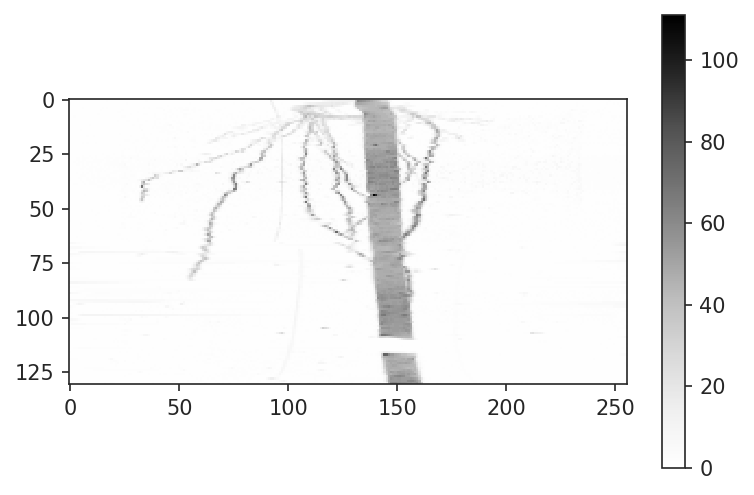

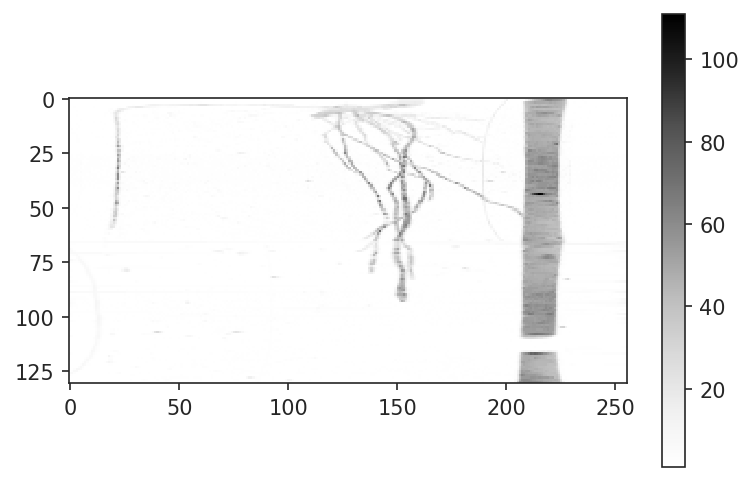

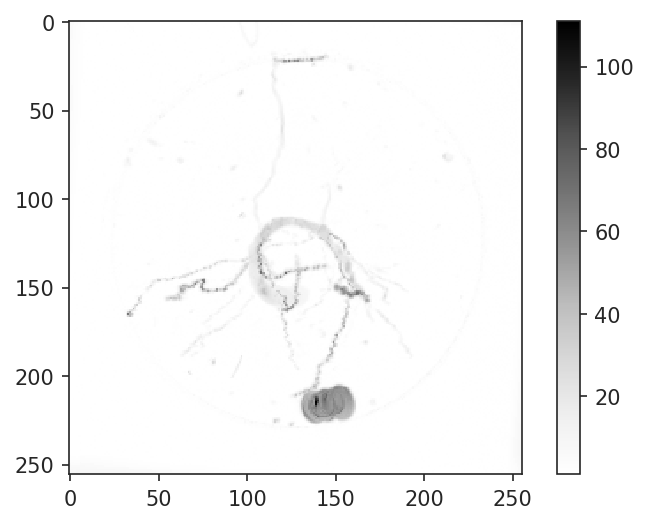

ground truth:


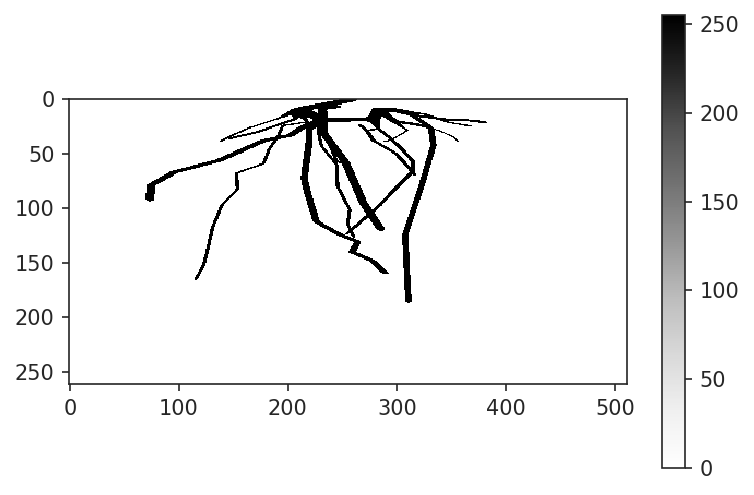

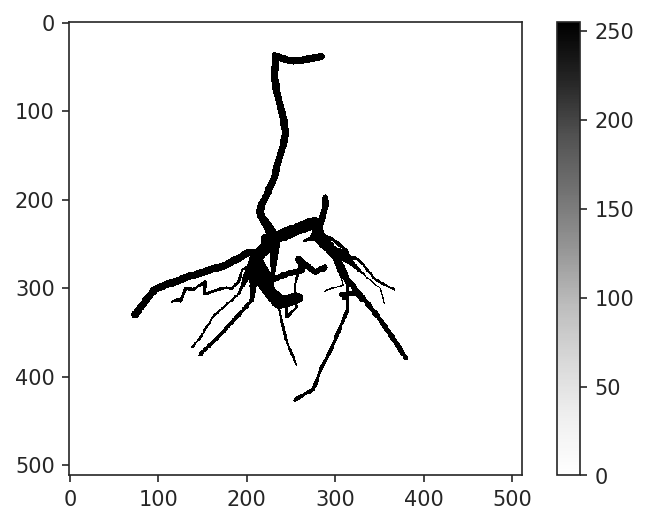

segmentation output:
(262, 512, 512)


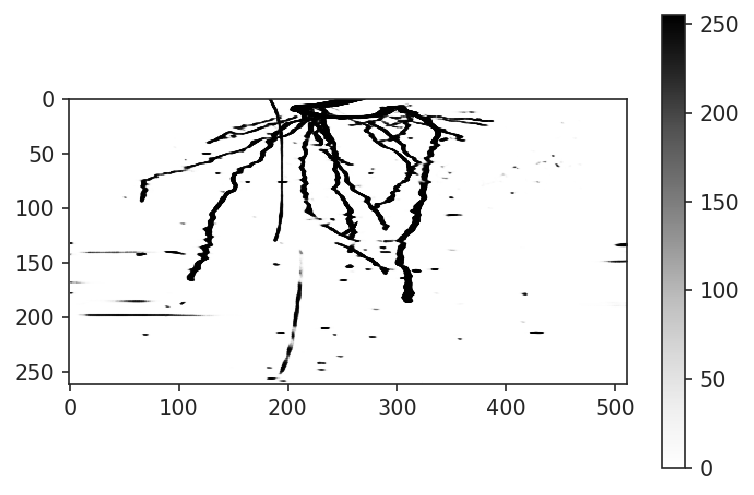

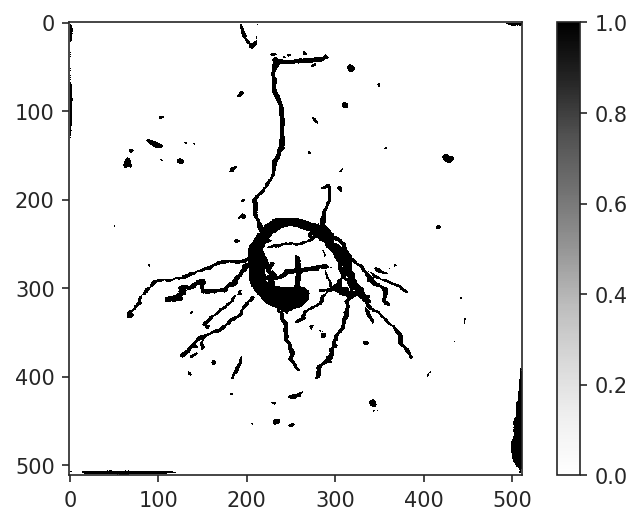

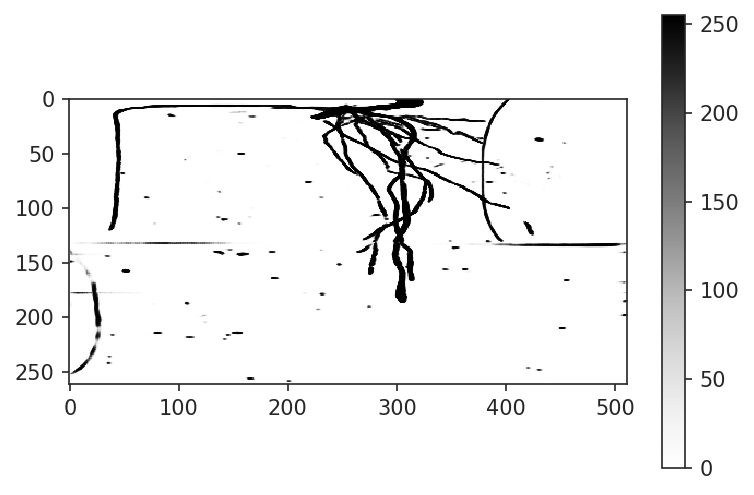

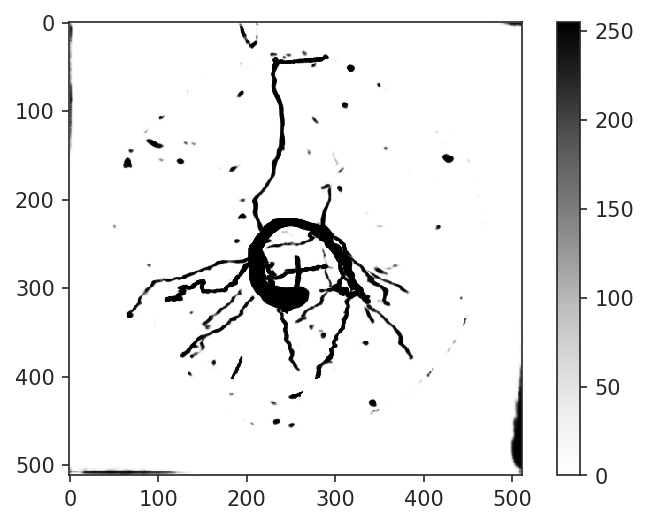


lupine_small_xml_mri.npy
noisy image:
(128, 1, 256, 256)


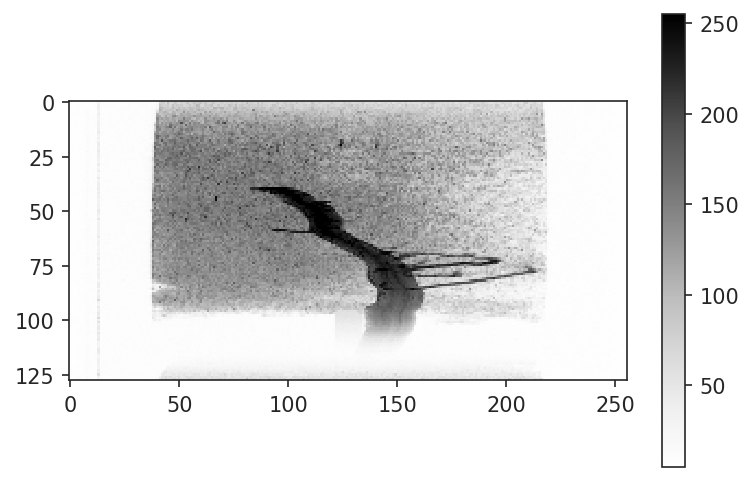

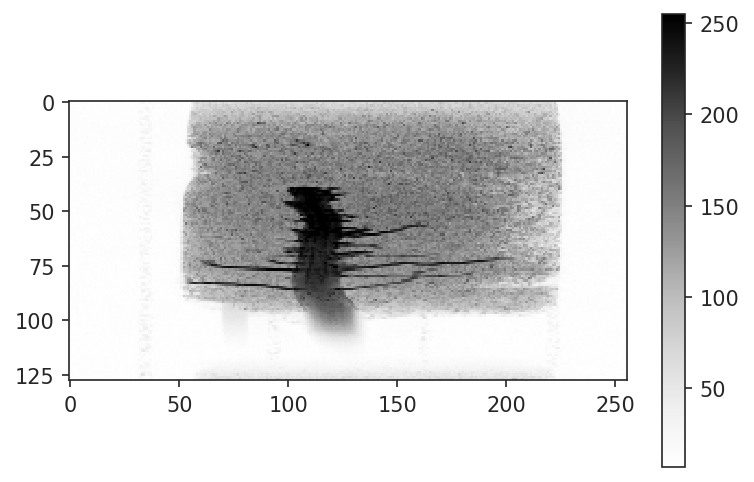

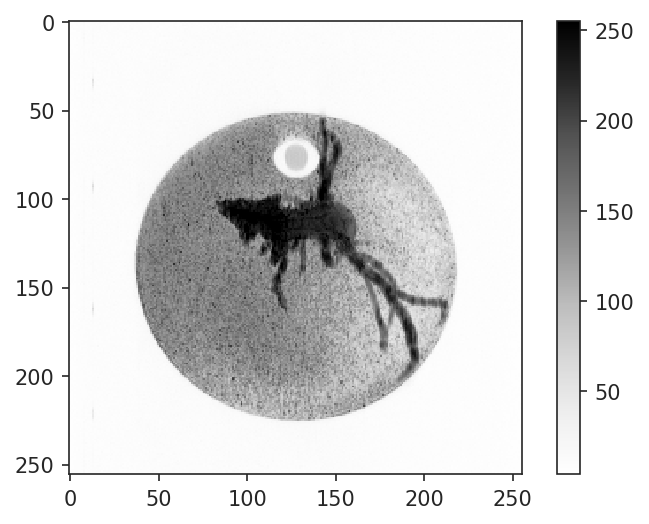

ground truth:


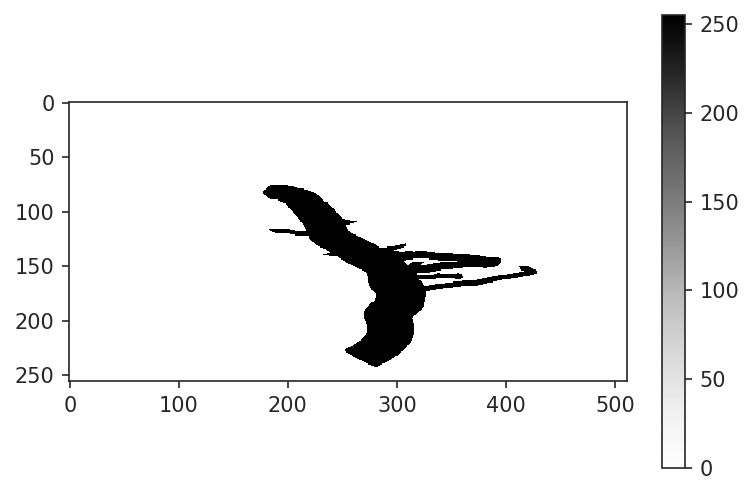

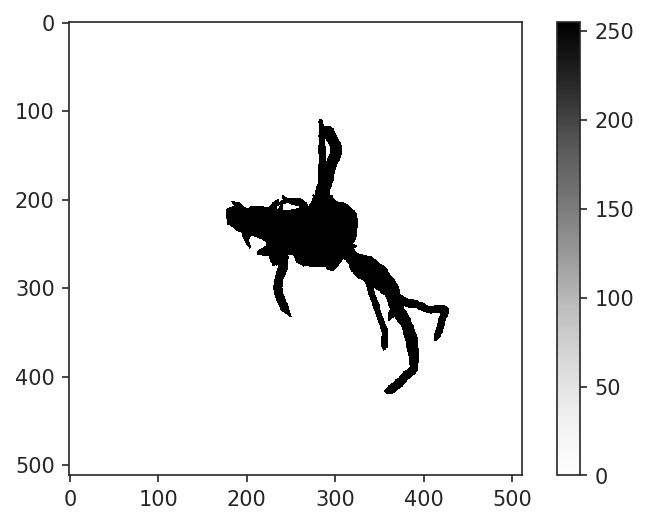

segmentation output:
(256, 512, 512)


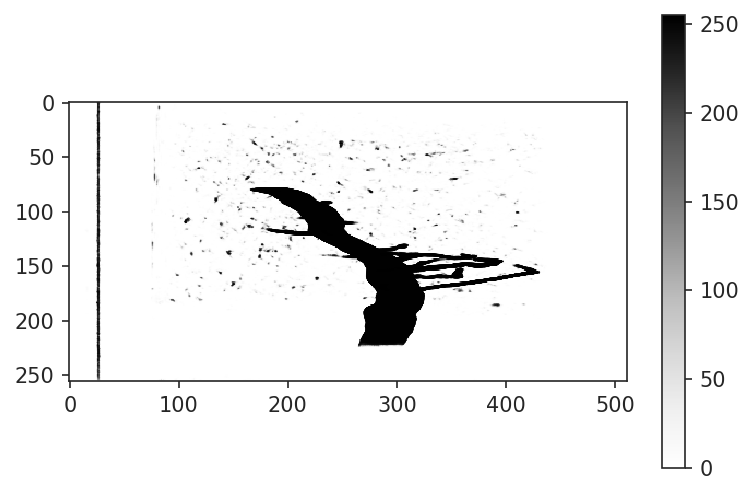

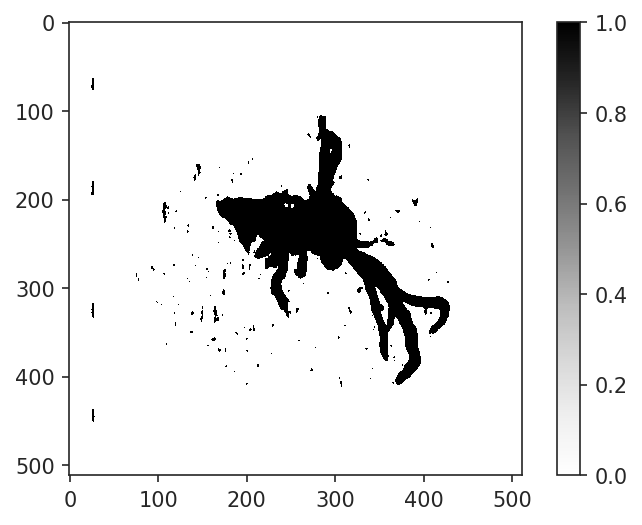

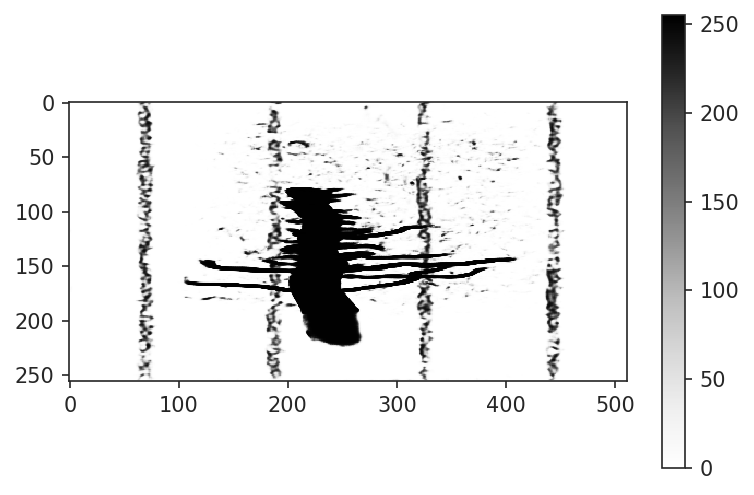

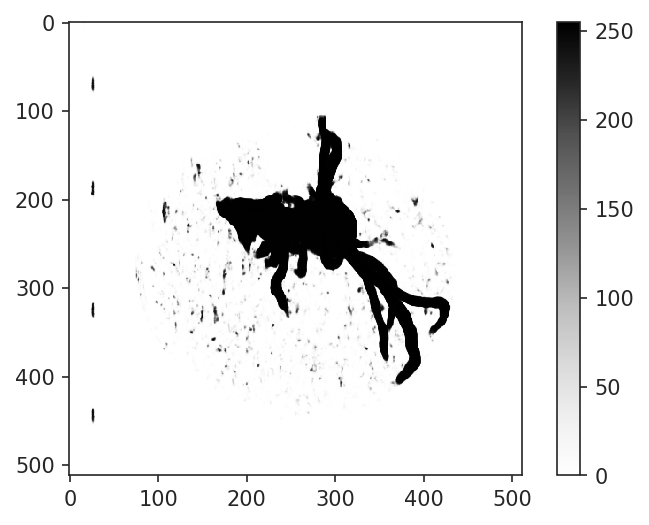


Lupine_22august_mri.npy
noisy image:
(120, 1, 256, 256)


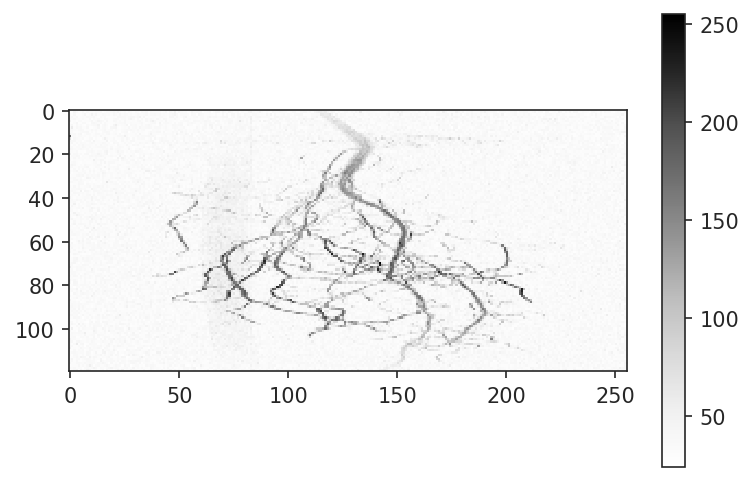

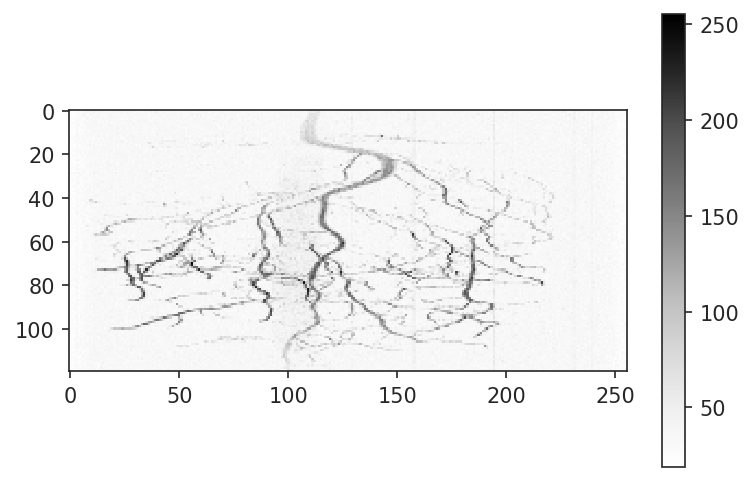

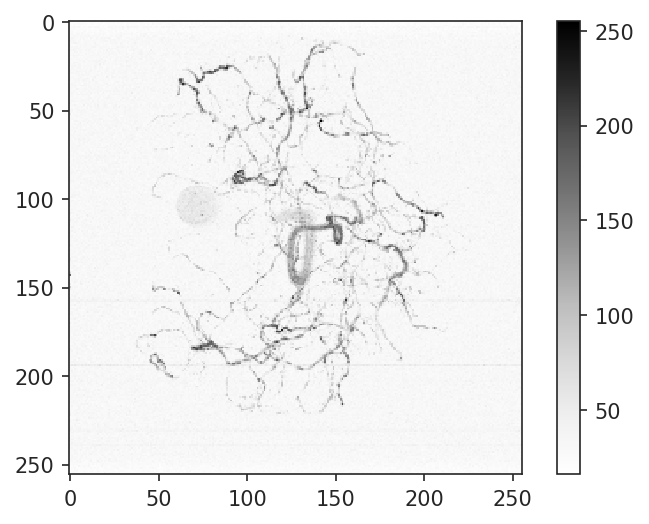

ground truth:


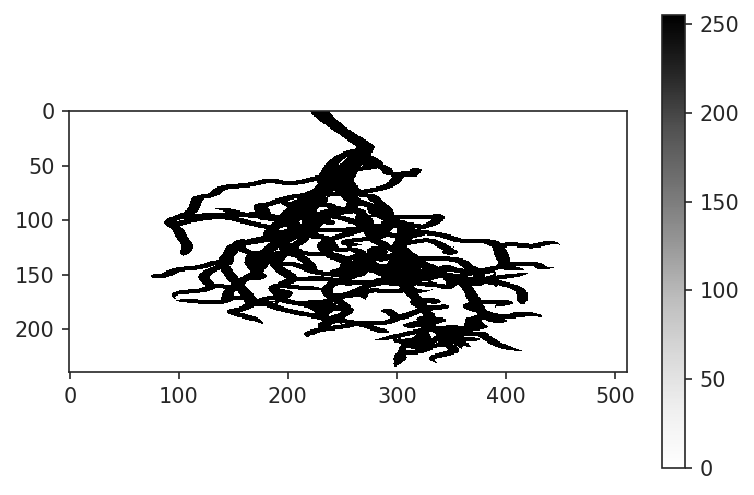

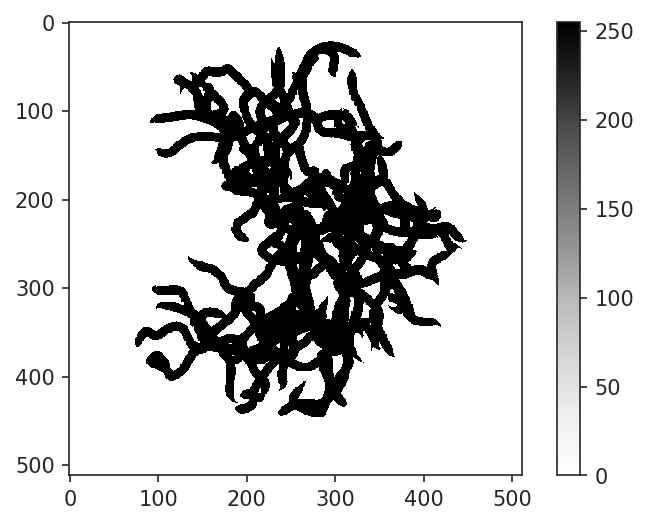

segmentation output:
(240, 512, 512)


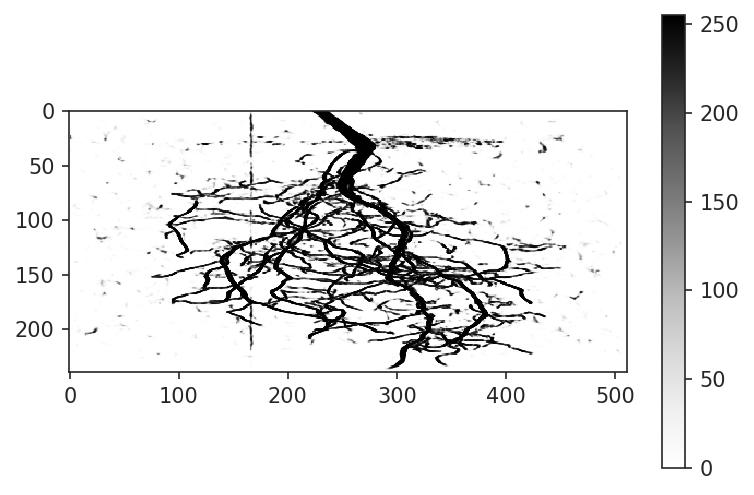

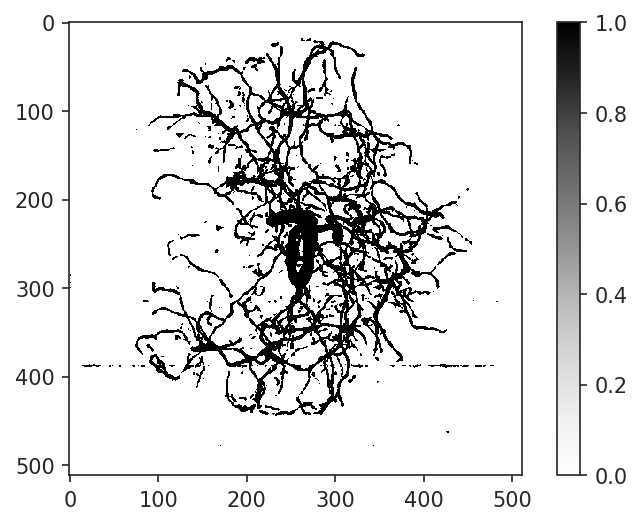

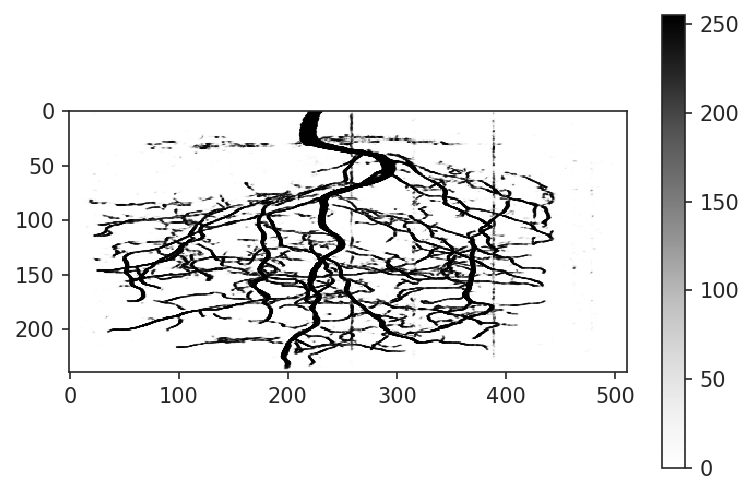

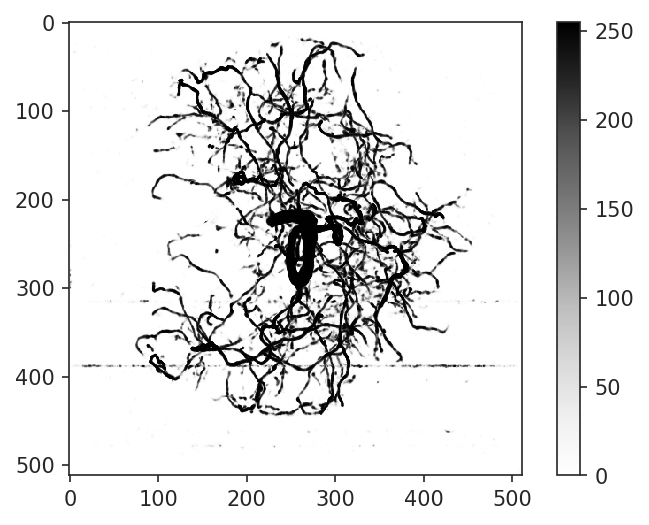


I_Sand_3D_DAP5_mri.npy
noisy image:
(70, 1, 256, 256)


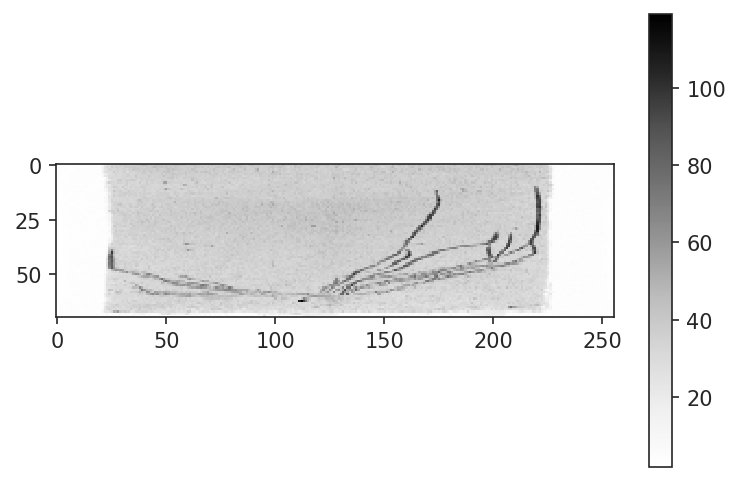

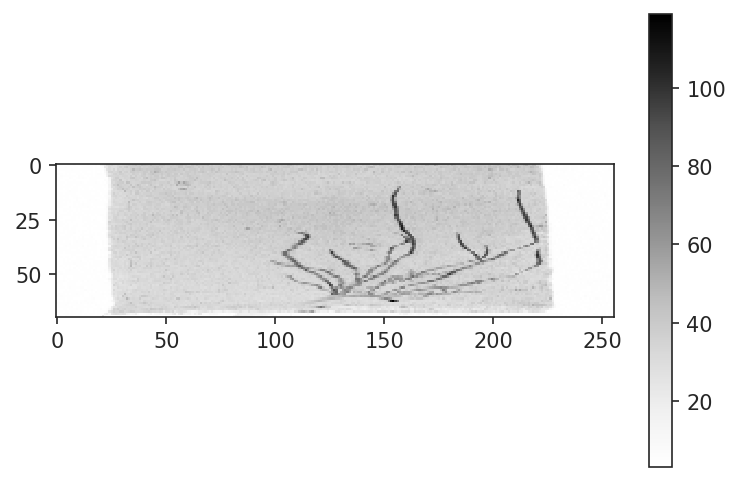

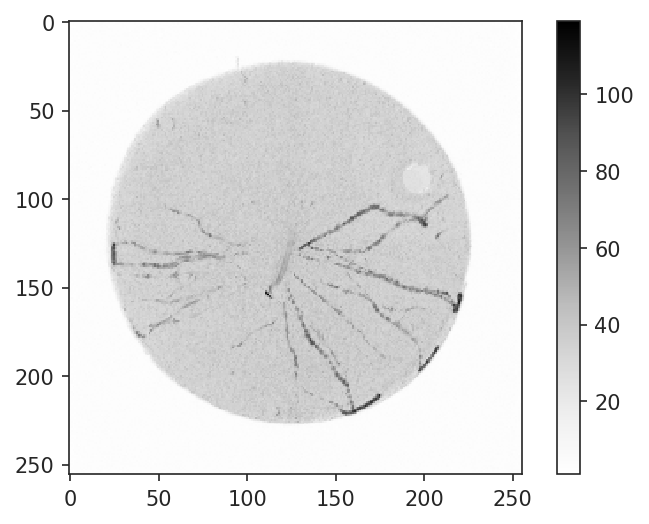

ground truth:


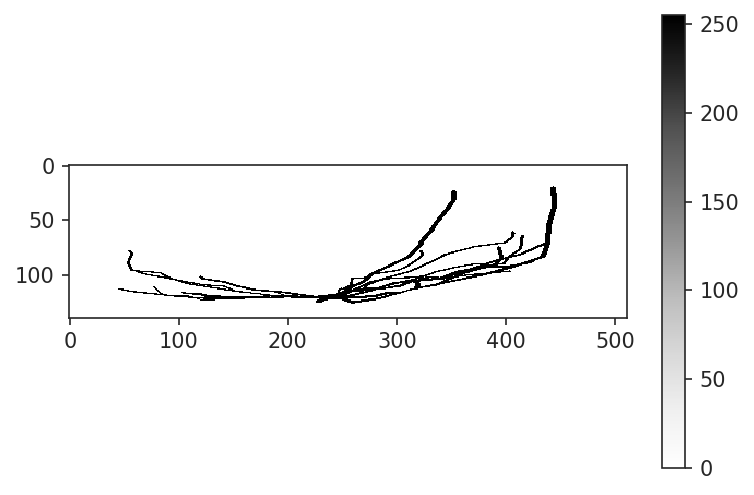

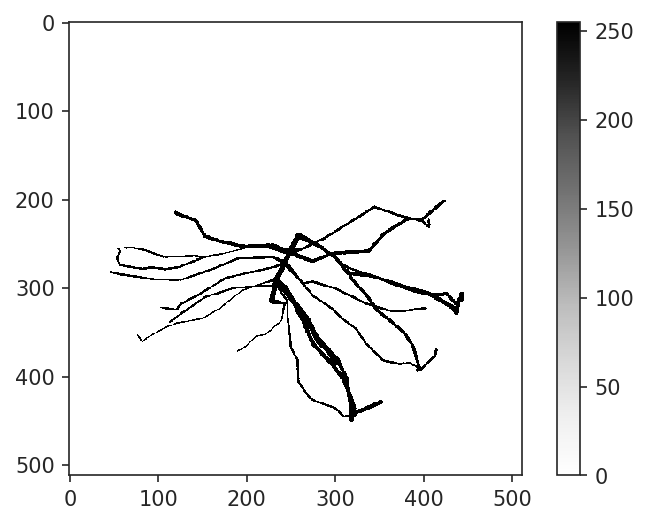

segmentation output:
(140, 512, 512)


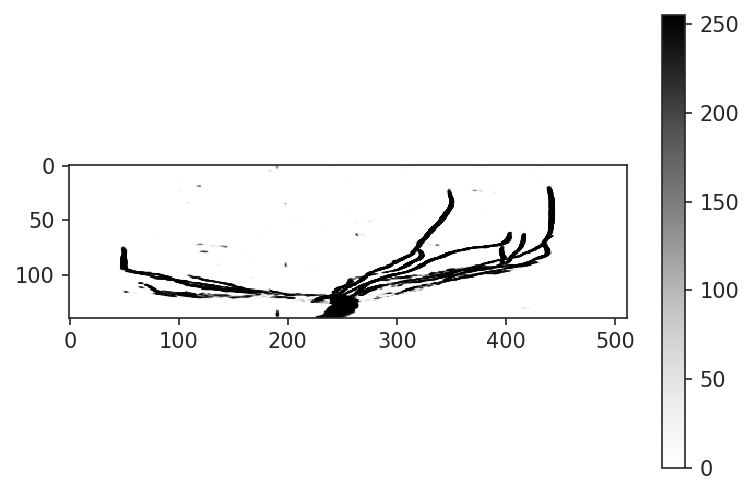

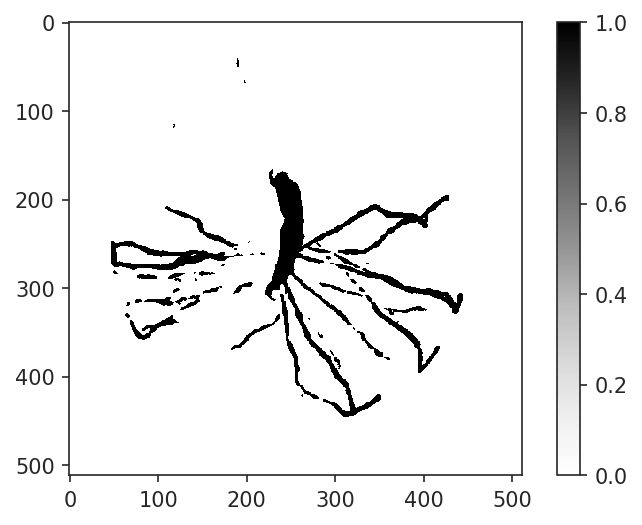

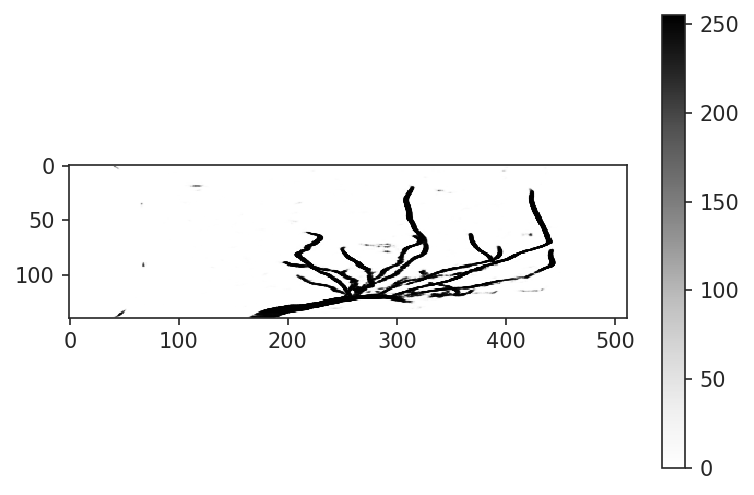

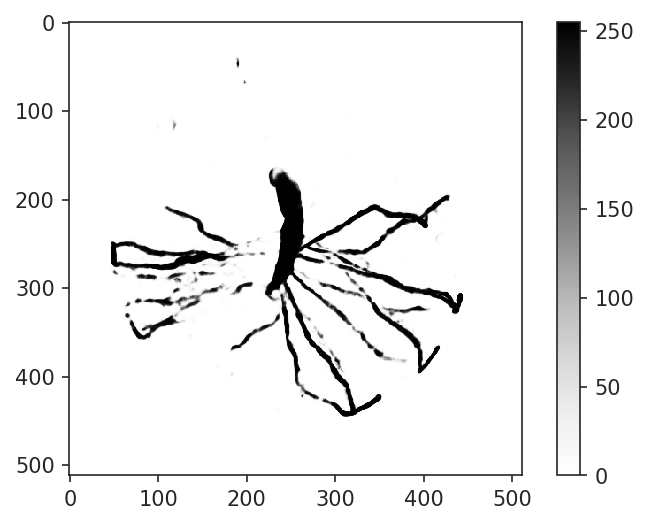


I_Soil_4D_DAP7_mri.npy
noisy image:
(137, 1, 256, 256)


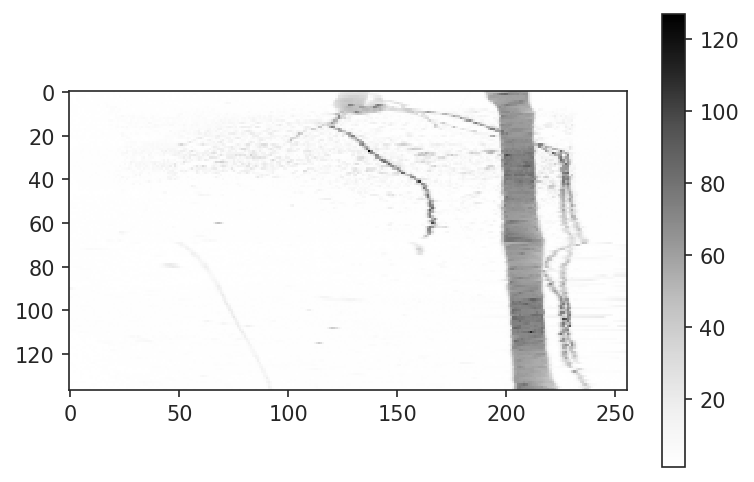

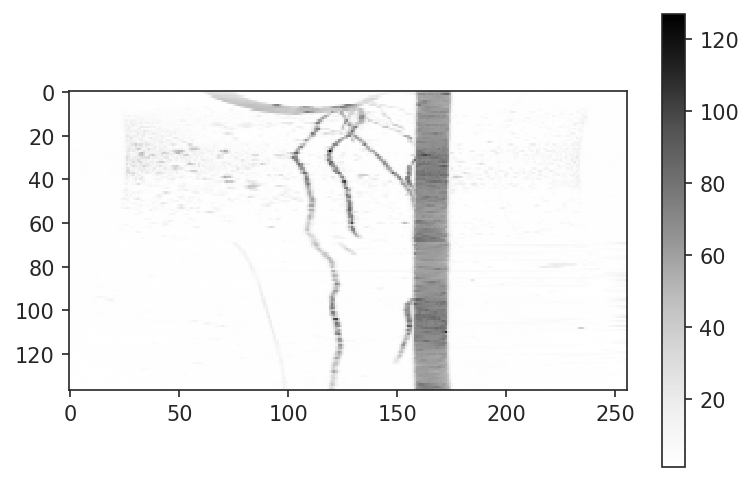

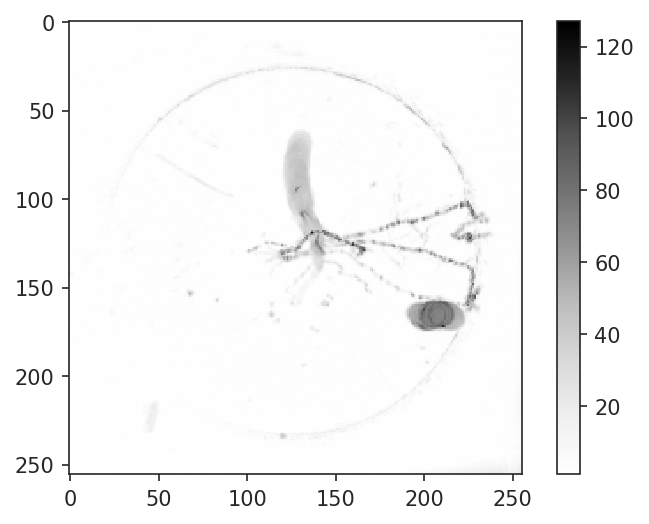

ground truth:


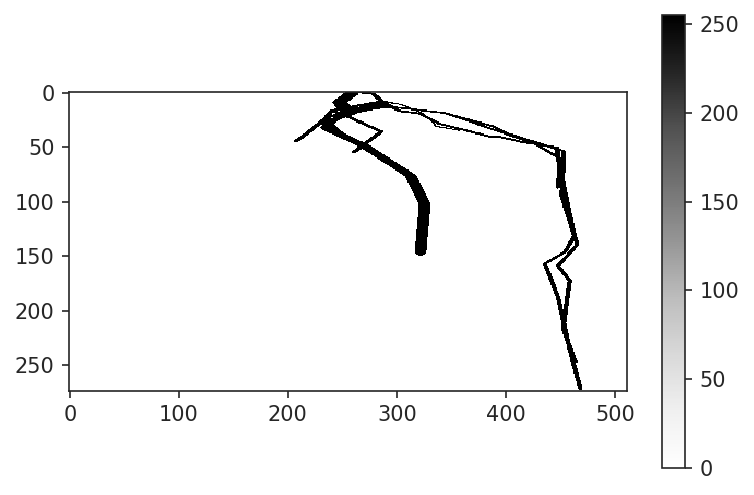

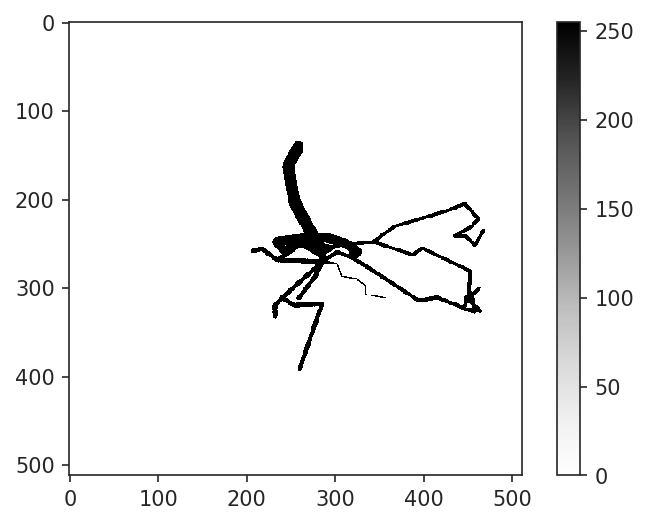

segmentation output:
(274, 512, 512)


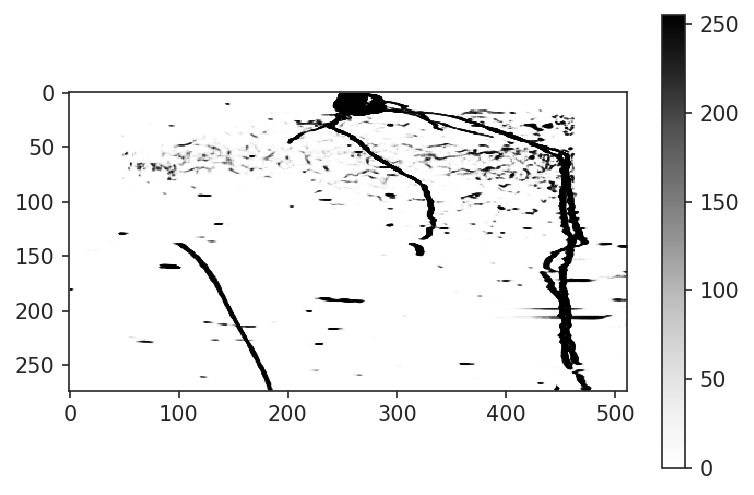

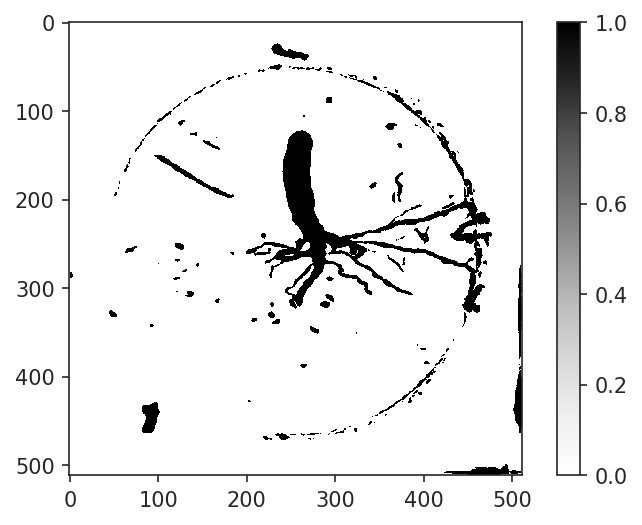

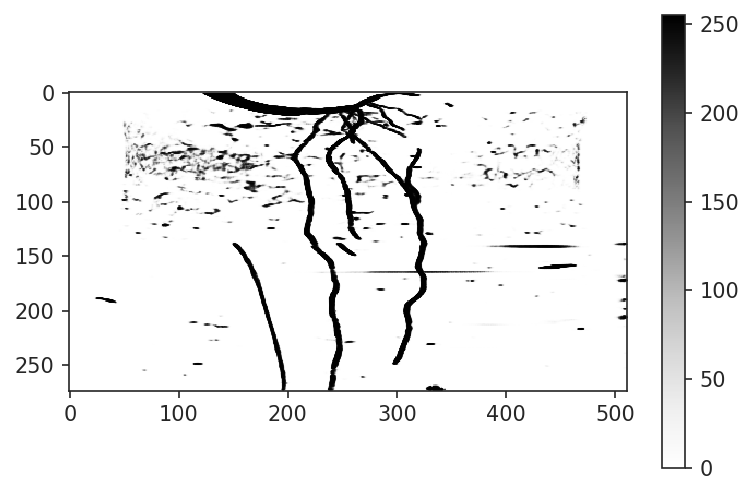

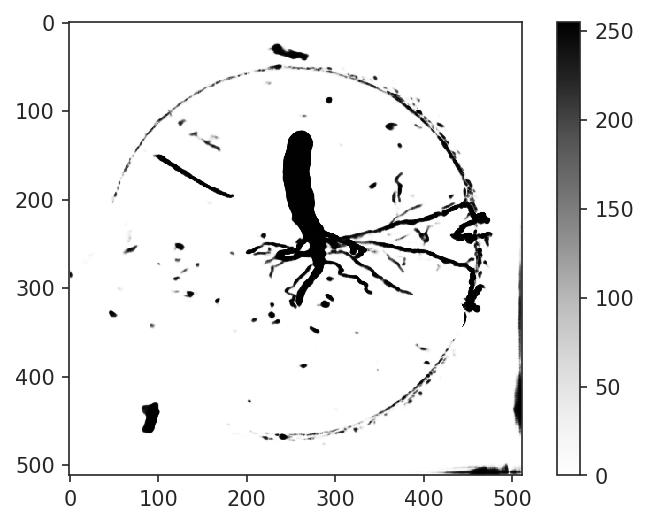

In [8]:
gt_dir = join(test_data_dir, 'ground_truth')
probability_threshold = 0.5
sns.set_style('ticks')


for fn in os.listdir(test_data_dir):
    if fn.endswith('.npy'):
        print(fn)
        print('noisy image:')
        img = np.load(join(test_data_dir, fn))
        print(img.shape)
        img = np.squeeze(img)
        plot_merged_slices(img, 'x', 0, img.shape[1])
        plot_merged_slices(img, 'y', 0, img.shape[2])
        plot_merged_slices(img, 'z', 0, img.shape[0])
        
        gt = np.load(join(gt_dir, 'gt_{}x_{}'.format(super_res, fn)))
        gt = np.squeeze(gt)
        print('ground truth:')
        plot_merged_slices(gt, 'x', 0, gt.shape[1])
        plot_merged_slices(gt, 'z', 0, gt.shape[0])
        
        if fn in tube_mask_info:
            # generate the test tube mask for this data
            center_x = tube_mask_info[fn]['center_x'] * super_res
            center_y = tube_mask_info[fn]['center_y'] * super_res
            rad = tube_mask_info[fn]['radius'] * super_res
            tube_mask = generate_tube_mask(gt.shape, center_x, center_y, rad)
        
        out = np.load(join(vis_output_dir, 'visualized_out_'+fn.strip('.npy')+'.npz'))['arr_0']
        print('segmentation output:')
        print(out.shape)
        # plot_one_slice(out, 'x', out.shape[1]//2)
        if fn in tube_mask_info:
            out[tube_mask] = 0
        plot_merged_slices(out, 'x', 0, out.shape[1])
        plot_merged_slices((out>255*probability_threshold).astype(int), 'z', 0, out.shape[0])
        plot_merged_slices(out, 'y', 0, out.shape[2])
        plot_merged_slices(out, 'z', 0, out.shape[0])
        
        
        print()

### Get the corresponding ground truth of each segmentation output

In [9]:
# The list of soil data names used for generating noisy root data
soil_names = ['Sand2_new', 'sand_d1', 'sand_unsat_0.39%wc', 'sand_unsat_0.23%wc', 'sand_unsat_0.18%wc', 
              'Sand1_new', 'sand_d2', 'sand_sat_0.43%wc', 'sand_unsat_0.27%wc', 'sand_unsat_0.34%wc']

# get the dicts of real/virtual test data, with key the test data name, value the gt name
virtual_test_root_gt_dict = {}
real_test_root_gt_dict = {}
for fn in os.listdir(test_data_dir):
    if fn.endswith('.npy'):
        gt_name, is_real = get_gt_filename(fn, super_res, soil_names)
        if is_real:
            real_test_root_gt_dict[fn] = gt_name
        else:
            virtual_test_root_gt_dict[fn] = gt_name
        # print(gt_name)
        # print(np.load(join(gt_dir, gt_name)).shape)
        
print('dict of real test data:', real_test_root_gt_dict)
print('dict of virtual test data:', virtual_test_root_gt_dict)

dict of real test data: {'I_Soil_1W_DAP7_mri.npy': 'gt_2x_I_Soil_1W_DAP7_mri.npy', 'lupine_small_xml_mri.npy': 'gt_2x_lupine_small_xml_mri.npy', 'Lupine_22august_mri.npy': 'gt_2x_Lupine_22august_mri.npy', 'I_Sand_3D_DAP5_mri.npy': 'gt_2x_I_Sand_3D_DAP5_mri.npy', 'I_Soil_4D_DAP7_mri.npy': 'gt_2x_I_Soil_4D_DAP7_mri.npy'}
dict of virtual test data: {}


## 2. Calculate the distance-tolerant F1 scores with different distance tolerances
test tubes will be ignored using masks. Default probability threshold is 0.5.

The returned values of calc_disTolFscore( ):
- real_data_F_list_dict: a dict, each key is a data name, each value is the list of distance-tolerant F1 scores corresponding to it
- real_data_precision_list_dict: a dict, each key is a data name, each value is a list of the precision values used to calculate the distance-tolerant F1 scores
- real_data_recall_list_dict: a dict, each key is a data name, each value is a list of the recall values used to calculate the distance-tolerant F1 scores
- distance_tolerance_range: a list of the different distance tolerance values used in the calculation, from the lowest to the highest. These values are defined by the user when setting the arguments earlier in this notebook.
- list_recall_by_radius: The list of recalls of different radius ranges. Usually not returned unless input argument radius_histogram is set to True, and in that case radius_grids files need to be present in the test_data_dir for each test data.

These returned values are also pickled and saved in the vis_output_dir under the same names. So that they can be loaded again for further visualizations.

In [15]:
real_data_F_list_dict, real_data_precision_list_dict, real_data_recall_list_dict, \
           distance_tolerance_range, radius_recall_list_all = calc_disTolFscore(vis_output_dir, test_data_dir, super_res, 
                                                        train_data_padding=input_padding)


out_dir: /home/user/zhaoy/root_mri/temp/debug_out_dir/test_prediction_runner/output_dir/temp
%%%%%%%% data name: I_Soil_1W_DAP7_mri.npy
distance tolerance: 0
f_score: 0.2749147422318061
precision: 0.25588427735238467
recall: 0.2970032840722496
*** total time used: 0.5292820930480957

distance tolerance: 2
f_score: 0.5357686382547663
precision: 0.5028205626978373
recall: 0.5733374384236454
*** total time used: 1.7990658283233643

distance tolerance: 4
f_score: 0.7110546760196708
precision: 0.6689419795221843
recall: 0.7588259441707718
*** total time used: 1.7954702377319336

distance tolerance: 6
f_score: 0.8134834417934834
precision: 0.7611982528426674
recall: 0.8734811165845648
*** total time used: 1.814192295074463

distance tolerance: 8
f_score: 0.8718107746398532
precision: 0.8092097119312455
recall: 0.9449096880131362
*** total time used: 1.8142962455749512

distance tolerance: 10
f_score: 0.8989186520991926
precision: 0.8283612442306673
recall: 0.9826149425287356
*** total time u

## 3. Load evaluation results for plotting
Load the pickled lists of distance tolerant F1 scores of trained models and plot

In [17]:
out_dir = '/home/user/zhaoy/root_mri/temp/debug_out_dir/test_prediction_runner/output_dir/temp'
real_data_F_list_dict, distance_tolerance_range, \
real_data_precision_list_dict, real_data_recall_list_dict = load_metrics_lists(out_dir)


### Example below: plot the distance tolerant F1 score curve of one model

In [18]:
dict_to_plot = {'distance tolerance':[], 'F1':[], 'test data': []}

for input_name in real_data_F_list_dict:
    dict_to_plot['F1'].extend(real_data_F_list_dict[input_name])
    dict_to_plot['distance tolerance'].extend(distance_tolerance_range)
    dict_to_plot['test data'].extend([input_name[:-8] for _ in range(len(distance_tolerance_range))])

df = pd.DataFrame(data=dict_to_plot) 

<Figure size 720x480 with 0 Axes>

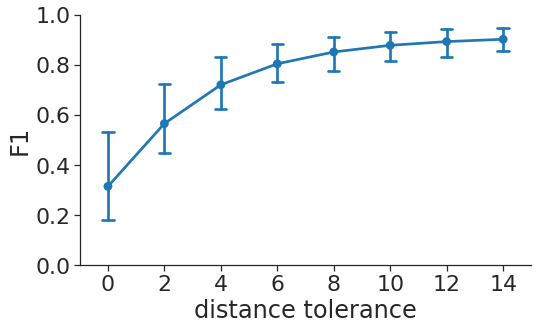

In [20]:
fig = plt.figure(dpi=120)  
sns.set_context("notebook", font_scale=2)
sns.set_style('ticks') 

ax = sns.catplot(x='distance tolerance', y='F1', data=df, kind="point", 
                 marker="o", aspect=1.6, capsize=.2, legend=True)  # ci=95


plt.ylim(0, 1)
plt.show()